# **Stadium Attendance Prediction**

## **Data Processing**

In [1]:
#Import necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import pickle
import shap

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path  = "drive/MyDrive/Colab Notebooks/"

In [4]:
df = pd.read_csv(path + "football_results.csv")

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981 entries, 0 to 980
Data columns (total 48 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Competition                     981 non-null    object 
 1   Matchday                        981 non-null    object 
 2   Time                            981 non-null    int64  
 3   Home Team                       981 non-null    object 
 4   Ranking Home Team               981 non-null    int64  
 5   Away Team                       981 non-null    object 
 6   Ranking Away Team               981 non-null    int64  
 7   Attendance                      981 non-null    int64  
 8   Weather                         981 non-null    object 
 9   Temperature (°C)                981 non-null    float64
 10  Date                            981 non-null    object 
 11  Weekday                         981 non-null    object 
 12  Month                           981 

In [6]:
df.head(10)

,Competition,Matchday,Time,Home Team,Ranking Home Team,Away Team,Ranking Away Team,Attendance,Weather,Temperature (°C),...,Day,Goals Scored in Last 5 Games,Goals Conceded in Last 5 Games,Number of Wins in Last 5 Games,Opposing team Category,Home team Category,Game day,Time slot,Weather GoodBad,Derby
0,Super League,1,20,FC Sion,8,FC Basel,3,11000,Clear or mostly clear,24.6,...,19,4.0,7.0,2.0,Top ranked,Medium ranked,Weekday,Night,Good,0
1,Super League,1,19,FC St. Gallen,2,FC Luzern,6,11672,Partly cloudy,24.0,...,20,4.0,7.0,1.0,Medium ranked,Top ranked,Weekend,Evening,Good,1
2,Challenge League,1,17,FC Winterthur,4,FC Aarau,8,3800,Partly cloudy,29.4,...,20,5.0,5.0,0.0,Medium ranked,Medium ranked,Weekend,Afternoon,Good,0
3,Super League,1,16,FC Zürich,7,FC Lugano,5,9430,Clear or mostly clear,26.8,...,21,5.0,6.0,1.0,Medium ranked,Medium ranked,Weekend,Afternoon,Good,0
4,Super League,1,16,BSC Young Boys,1,Servette FC,4,25110,Clear or mostly clear,26.0,...,21,14.0,1.0,5.0,Medium ranked,Top ranked,Weekend,Afternoon,Good,0
5,UEFA Europa League Qualifying,Second Round 1st leg,20,FC Luzern,0,KÍ Klaksvík,0,6344,Partly cloudy,26.4,...,25,10.0,2.0,4.0,Not ranked,Not ranked,Weekday,Night,Good,0
6,Challenge League,2,19,Lausanne-Sport,4,FC Chiasso,9,2135,Partly cloudy,20.8,...,27,8.0,8.0,1.0,Bottom ranked,Medium ranked,Weekend,Evening,Good,0
7,Super League,2,19,Servette FC,6,FC Sion,9,11142,Rainy,20.3,...,27,10.0,3.0,4.0,Bottom ranked,Medium ranked,Weekend,Evening,Bad,1
8,Super League,2,19,FC Basel,2,FC St. Gallen,8,21932,Partly cloudy,22.4,...,27,4.0,7.0,2.0,Medium ranked,Top ranked,Weekend,Evening,Good,0
9,Super League,2,16,FC Luzern,3,FC Zürich,10,9917,Rainy,17.7,...,28,1.0,0.0,1.0,Bottom ranked,Top ranked,Weekend,Afternoon,Bad,0


In [7]:
# Remove Data,where Percentage Attendance > 1
df.loc[df['PercentageAttendance'] > 1, 'PercentageAttendance'] = 1

In [8]:
# Group by  'Home Team' und calculate Percentiles for the Attendance for the Teams
team_stats = df.groupby('Home Team').agg(
    max_capacity=('Max Capacity', 'first'),  # MAx- Capacity for each team
    attendance_30th_percentile=('Attendance', lambda x: x.quantile(0.30)),  # 30. Percentile
    attendance_70th_percentile=('Attendance', lambda x: x.quantile(0.70))   # 70. percentile
).reset_index()

print(team_stats)

         Home Team  max_capacity  attendance_30th_percentile  \
0   BSC Young Boys       31783.0                     25282.1   
1         FC Basel       38512.0                     19527.0   
2        FC Lugano        6330.0                      2843.5   
3        FC Luzern       16800.0                     10105.5   
4          FC Sion       16232.0                      6500.0   
5    FC St. Gallen       20029.0                     15683.8   
6    FC Winterthur        8550.0                      5100.0   
7        FC Zürich       26104.0                     10870.0   
8     Grasshoppers       26104.0                      4049.6   
9   Lausanne-Sport       12544.0                      3773.6   
10     Servette FC       30084.0                      6076.6   
11   Yverdon Sport        6600.0                       712.6   

    attendance_70th_percentile  
0                      31120.0  
1                      22666.5  
2                       3509.6  
3                      13171.9  
4 

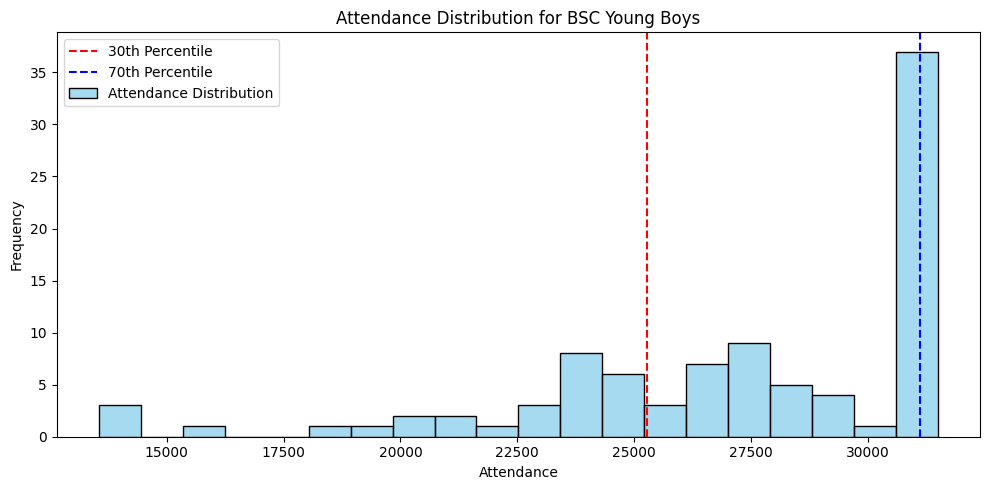

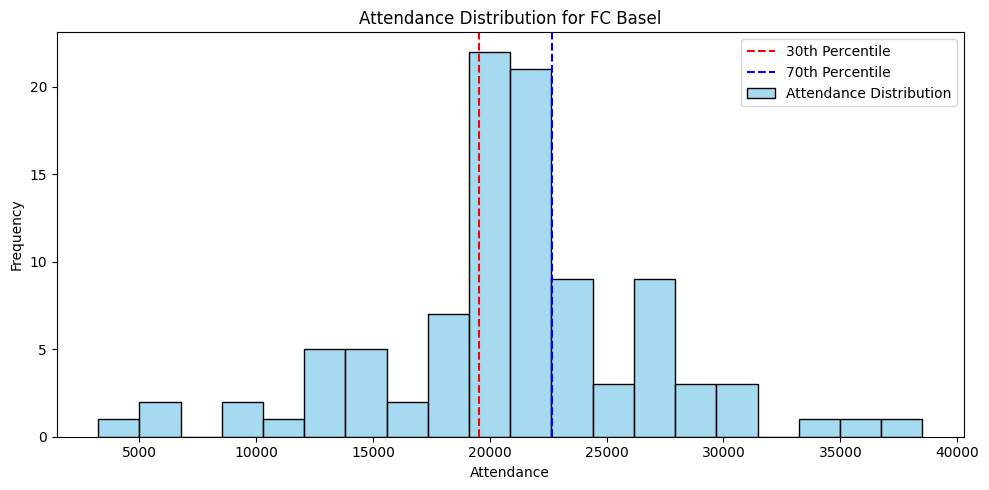

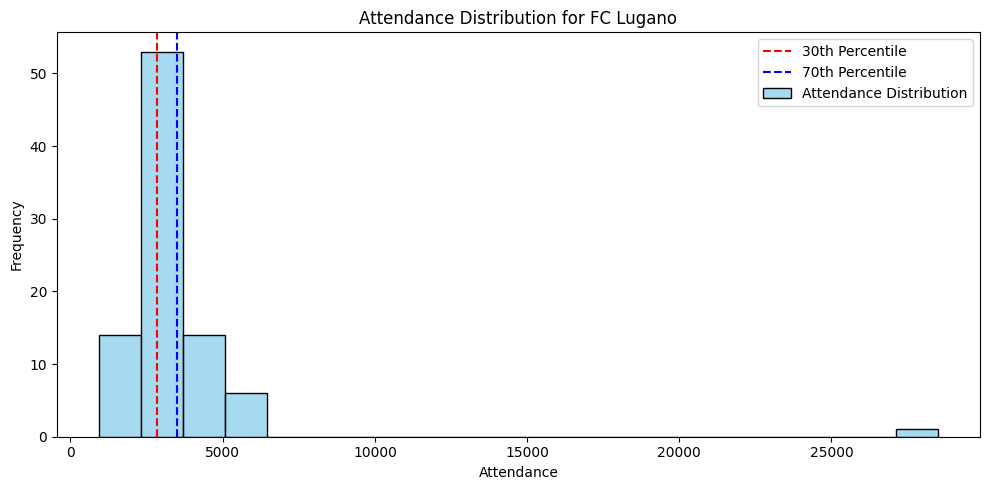

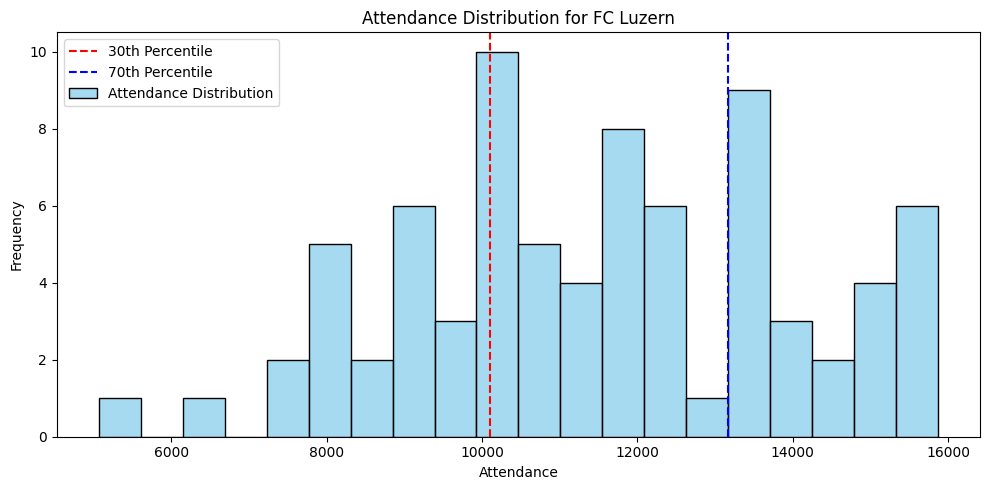

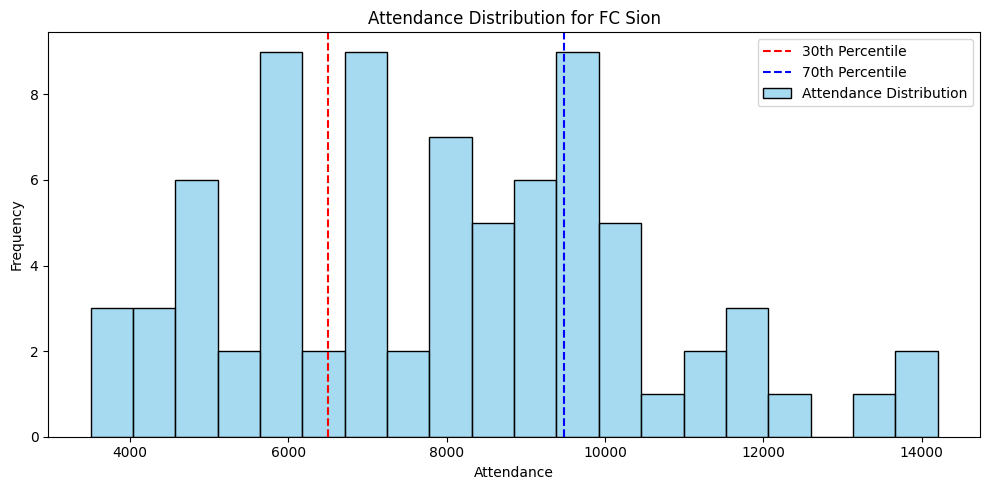

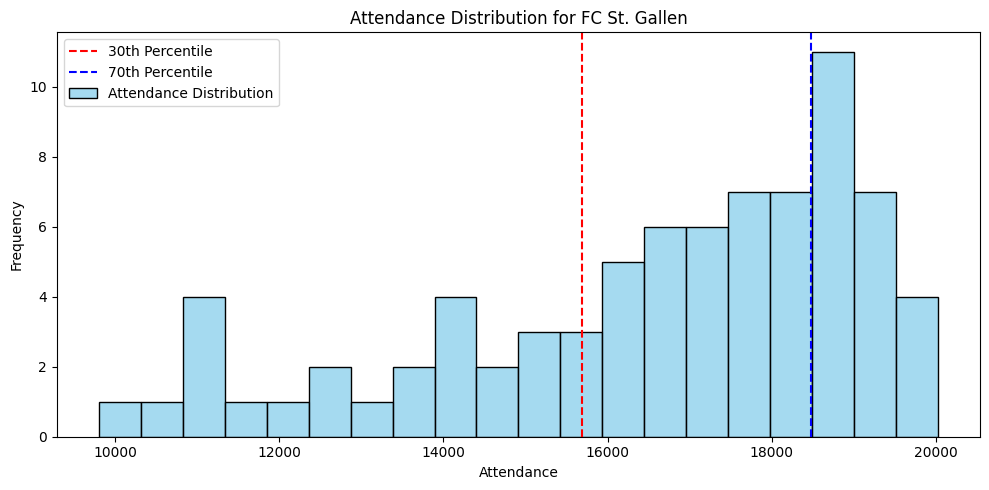

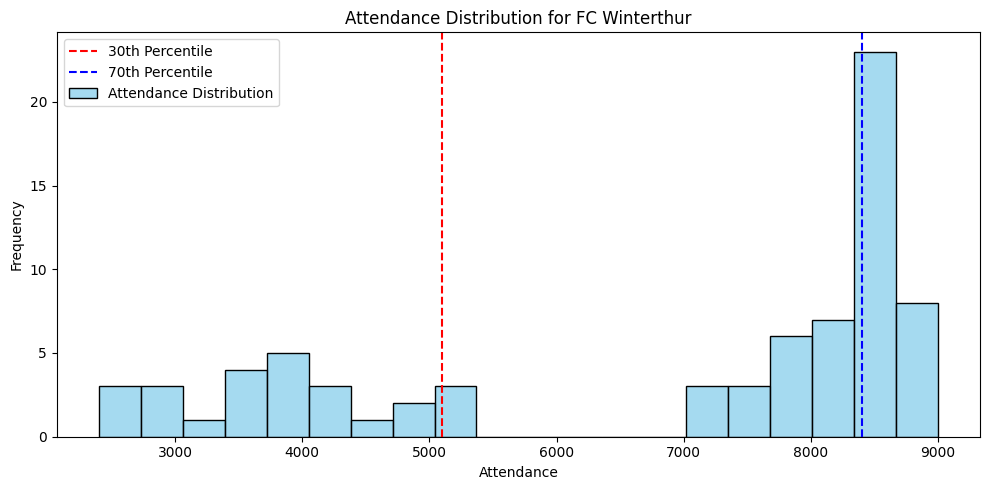

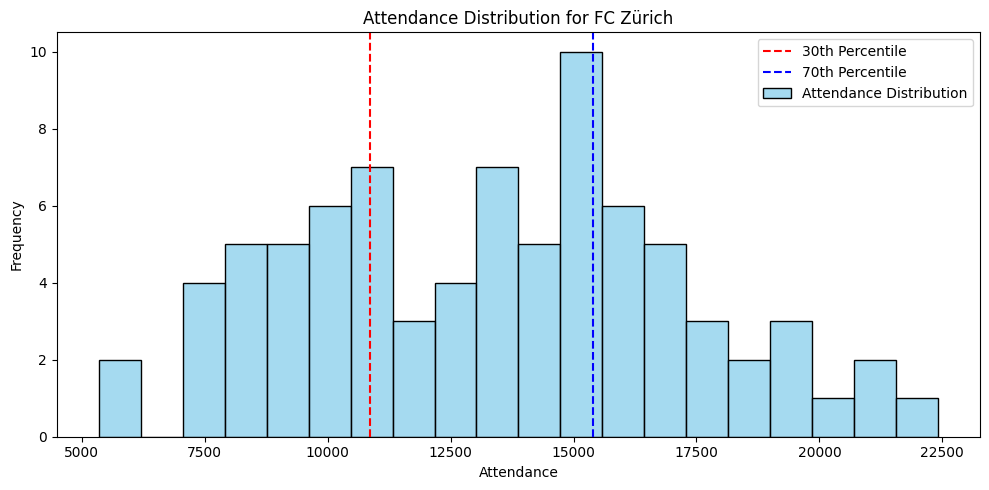

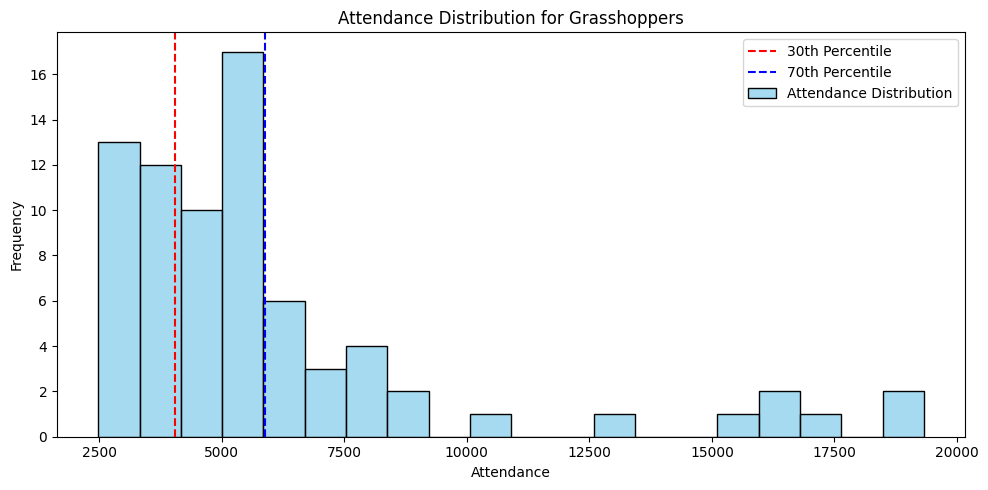

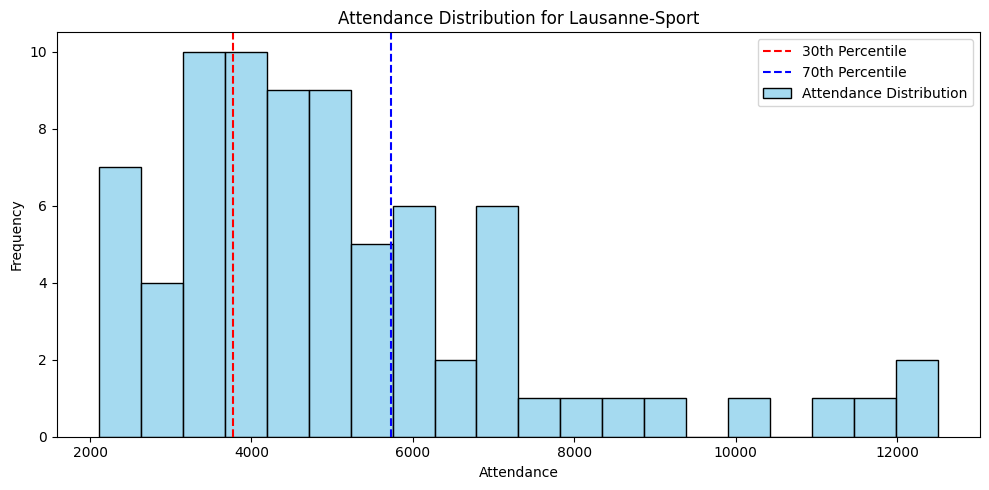

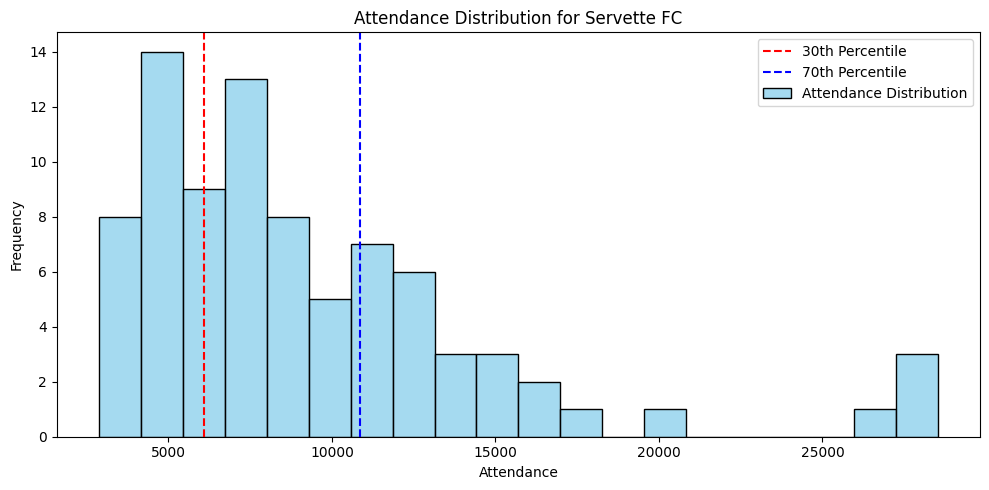

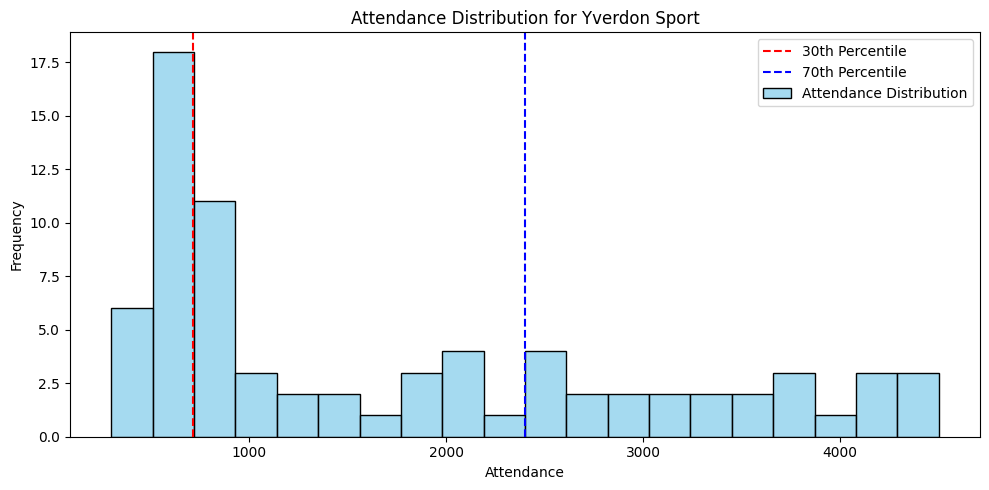

In [9]:
# Iterate through the different Home teams to visualise the specific Attendance Distributions for the Home Teams
for team in team_stats['Home Team']:
    team_data = df[df['Home Team'] == team]  # Filter data for the specific team
    attendance_30th = team_stats.loc[team_stats['Home Team'] == team, 'attendance_30th_percentile'].values[0]
    attendance_70th = team_stats.loc[team_stats['Home Team'] == team, 'attendance_70th_percentile'].values[0]

    plt.figure(figsize=(10, 5))
    sns.histplot(team_data['Attendance'], kde=False, bins=20, color="skyblue", label="Attendance Distribution")
    plt.axvline(attendance_30th, color='red', linestyle='--', label='30th Percentile')
    plt.axvline(attendance_70th, color='blue', linestyle='--', label='70th Percentile')
    plt.title(f"Attendance Distribution for {team}")
    plt.xlabel("Attendance")
    plt.ylabel("Frequency")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [10]:
#League Table, to visualize in streamlit application
data = {
    "Team": [
        "FC Basel", "FC Lugano", "Servette FC", "FC Zürich", "FC Luzern",
        "Lausanne-Sport", "FC St. Gallen", "FC Sion", "BSC Young Boys",
        "Yverdon Sport", "FC Winterthur", "Grasshoppers"
    ],
    "Ranking": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
    "Goals_Scored_in_Last_5_Games": [12, 10, 8, 10, 12, 10, 8, 8, 8, 8, 12, 12],
    "Goals_Conceded_in_Last_5_Games": [5, 6, 7, 6, 5, 6, 7, 7, 7, 7, 5, 5],
    "Number_of_Wins_in_Last_5_Games": [3, 2, 1, 1, 2, 3, 1, 2, 3, 0, 1, 0],
    "Last_1_Game_Result": ["Tie", "Lose", "Win", "Tie", "Win", "Tie", "Lose", "Win", "Win", "Lose", "Lose", "Tie"],
    "Last_2_Game_Result": ["Win", "Win", "Lose", "Lose", "Tie", "Win", "Tie", "Lose", "Tie", "Tie", "Tie", "Tie"],
    "Last_3_Game_Result": ["Win", "Lose", "Tie", "Tie", "Lose", "Lose", "Win", "Win", "Win", "Lose", "Win", "Lose"],
    "Last_4_Game_Result": ["Win", "Win", "Lose", "Tie", "Win", "Win", "Tie", "Tie", "Tie", "Lose", "Lose", "Lose"],
    "Last_5_Game_Result": ["Lose", "Tie", "Tie", "Win", "Tie", "Win", "Tie", "Lose", "Win", "Lose", "Tie", "Tie"]
}

# Create the dataframe
league_df = pd.DataFrame(data)

# Save to a CSV file
file_path = 'league_table_combined.csv'
league_df.to_csv(path + file_path, index=False)

### Multikollinearität

Home Team  BSC Young Boys  FC Basel  FC Lugano  FC Luzern  FC Sion  \
Canton                                                               
BE                     94         0          0          0        0   
BS                      0        98          0          0        0   
GE                      0         0          0          0        0   
LU                      0         0          0         78        0   
SG                      0         0          0          0        0   
TI                      0         0         88          0        0   
VD                      0         0          0          0        0   
VS                      0         0          0          0       78   
ZH                      0         0          0          0        0   

Home Team  FC St. Gallen  FC Winterthur  FC Zürich  Grasshoppers  \
Canton                                                             
BE                     0              0          0             0   
BS                     0 

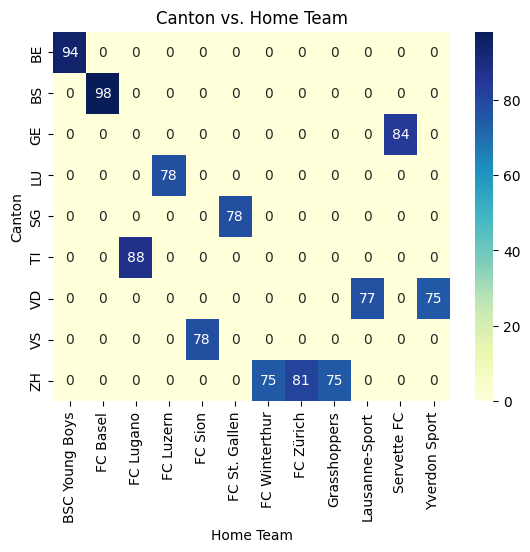

In [11]:
#Correlation between Canton and Stadium
crosstab_home_team = pd.crosstab(df['Canton'], df['Home Team'])


print(crosstab_home_team)

# Visualization
sns.heatmap(crosstab_home_team, cmap="YlGnBu", annot=True, fmt="d")
plt.title('Canton vs. Home Team')
plt.xlabel('Home Team')
plt.ylabel('Canton')
plt.show()

Full Roof              0.0  1.0
Stadium                        
Cornaredo Stadium       88    0
Letzigrund               0  156
St. Jakob-Park           0   98
Stade Municipal         75    0
Stade Tourbillon         0   78
Stade de Genève          0   84
Stade de la Tuilière     0   77
Stadion Schützenwiese   75    0
Swissporarena            0   78
Wankdorf Stadium         0   94
kybunpark                0   78


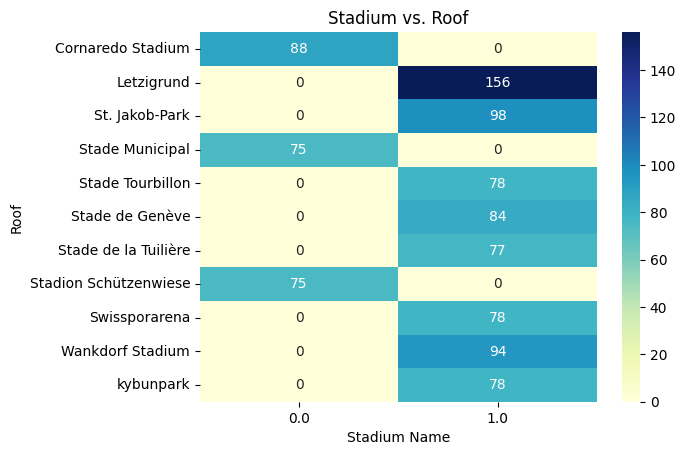

In [12]:
# Correlation between Stadium and Type of Roof
crosstab_home_team = pd.crosstab(df['Stadium'], df['Full Roof'])


print(crosstab_home_team)

# Visualization
sns.heatmap(crosstab_home_team, cmap="YlGnBu", annot=True, fmt="d")
plt.title('Stadium vs. Roof')
plt.xlabel('Stadium Name')
plt.ylabel('Roof')
plt.show()

Stadium         Cornaredo Stadium  Letzigrund  St. Jakob-Park  \
Home Team                                                       
BSC Young Boys                  0           0               0   
FC Basel                        0           0              98   
FC Lugano                      88           0               0   
FC Luzern                       0           0               0   
FC Sion                         0           0               0   
FC St. Gallen                   0           0               0   
FC Winterthur                   0           0               0   
FC Zürich                       0          81               0   
Grasshoppers                    0          75               0   
Lausanne-Sport                  0           0               0   
Servette FC                     0           0               0   
Yverdon Sport                   0           0               0   

Stadium         Stade Municipal  Stade Tourbillon  Stade de Genève  \
Home Team          

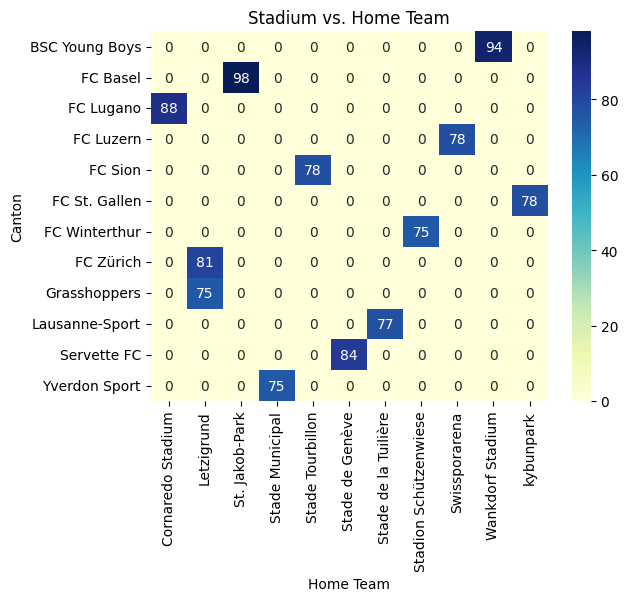

In [13]:
# Correlation between Home Team and Staium
crosstab_home_team = pd.crosstab(df['Home Team'], df['Stadium'])

print(crosstab_home_team)

#Visualization
sns.heatmap(crosstab_home_team, cmap="YlGnBu", annot=True, fmt="d")
plt.title('Stadium vs. Home Team')
plt.xlabel('Home Team')
plt.ylabel('Canton')
plt.show()

---
**Analysis**

Based on the provided heatmaps, it becomes evident that the variables stadium, canton, city, roof type, and home team are strongly correlated.

*   **Stadium and Home Team**: The first heatmap reveals that each stadium is assigned to exactly one home team. This indicates that information about the home team already covers the assignment to the respective stadium.

*  **Stadium and Roof Type**: The second heatmap shows that stadiums are also associated with specific roof types. Since the stadium is directly dependent on the home team, the roof information is implicitly included in the home team variable as well.


*   **Canton and Home Team:** The third heatmap demonstrates that each home team is uniquely assigned to a canton. This underscores that canton information is also redundant, as it is already captured by the home team variable.

Given these close relationships, it is reasonable to remove variables such as stadium, canton, city, and roof type from the model, as all relevant information is already contained in the home team variable. This reduces multicollinearity and simplifies the analysis without losing critical information.

In [14]:
# From our Dataset can be a lot of Features deleted
df.drop(['Date'], axis=1, inplace=True) # Split up in Weekday, Time, Month
df.drop(['Attendance'], axis=1, inplace=True) #Attendance Percentage as Target
df.drop(['Year'], axis=1, inplace=True)
df.drop(['Season'], axis=1, inplace=True)
df.drop(['quarter'], axis=1, inplace=True) #Included in 'Month'
df.drop(['Max Capacity'], axis=1, inplace=True) #Relevant to calculate Percentage Attendance
df.drop(['Full Roof'], axis=1, inplace=True) # Included in the Feature 'Stadium' and therefore in 'Home Team'
df.drop(['Canton_BE'], axis=1, inplace=True) # Included in the Feature 'Home Team'
df.drop(['Canton_BS'], axis=1, inplace=True)
df.drop(['Canton_GE'], axis=1, inplace=True)
df.drop(['Canton_LU'], axis=1, inplace=True)
df.drop(['Canton_SG'], axis=1, inplace=True)
df.drop(['Canton_TI'], axis=1, inplace=True)
df.drop(['Canton_VD'], axis=1, inplace=True)
df.drop(['Canton_VS'], axis=1, inplace=True)
df.drop(['Canton_ZH'], axis=1, inplace=True)
df.drop(['Match Type'], axis=1, inplace=True)
df.drop(['Stadium'], axis=1, inplace=True) # Included in the Feature 'Home Team'
df.drop(['City'], axis=1, inplace=True) # Included in the Feature 'Home Team'
df.drop(['Canton'], axis=1, inplace=True) # Included in the Feature 'Home Team'
df.drop(['Home Team Outcome'], axis=1, inplace=True) #Feature from the Future
df.drop(['Away Team Outcome'], axis=1, inplace=True) #Feature from the Future
df.drop(['Last Month GDP'], axis=1, inplace=True)
df.drop(['Home Team Goals Scored'], axis=1, inplace=True) #Feature from the Future
df.drop(['Away Team Goals Scored'], axis=1, inplace=True) #Feature from the Future
df.drop(['Holiday'], axis=1, inplace=True)

In [15]:
# Delete Columns for  Promotion League and Super League Barrage
df = df[~df['Competition'].isin(['Promotion League', 'Promotion League - Aufstiegsrunde (bis 21/22)', 'Super League Barrage'])]

df['Competition'] = df['Competition'].replace({
    'UEFA Conference League Qualifiers': 'UEFA Conference League',
    'UEFA Champions League Qualifying': 'UEFA Champions League',
    'UEFA Europa League Qualifying': 'UEFA Europa League'
})

<ipython-input-15-82490eebfd41>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Competition'] = df['Competition'].replace({


In [16]:
# List of the Super League Teams
super_league_teams = [
    'FC Sion', 'FC St. Gallen', 'FC Winterthur', 'FC Zürich',
    'BSC Young Boys', 'FC Luzern', 'Lausanne-Sport', 'Servette FC',
    'FC Basel', 'FC Lugano', 'Grasshoppers', 'Yverdon Sport'
]

# Put all other teams as 'Unknown'
df['Away Team'] = df['Away Team'].apply(lambda team: team if team in super_league_teams else 'Unknown')

<ipython-input-16-cde585fc3ed1>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Away Team'] = df['Away Team'].apply(lambda team: team if team in super_league_teams else 'Unknown')


In [17]:
# Identification of categorial columns
categorical_columns = [
    "Competition",
    "Matchday",
    "Home Team",
    "Away Team",
    "Weekday"
]

# Dummy-Encoding
df_encoded = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

In [18]:
# Identification of categorial columns, where complete Dummy-Codierung is used for easier Feature Importance Analysis later

categorial_columns_2 = [
    "Opposing team Category",
    "Home team Category",
    "Game day",
    "Time slot",
    "Weather GoodBad",
    "Weather",
]

df_encoded = pd.get_dummies(df_encoded, columns=categorial_columns_2, drop_first=False)

In [19]:
df_encoded = df_encoded.astype(float)

## **Data Exploration**

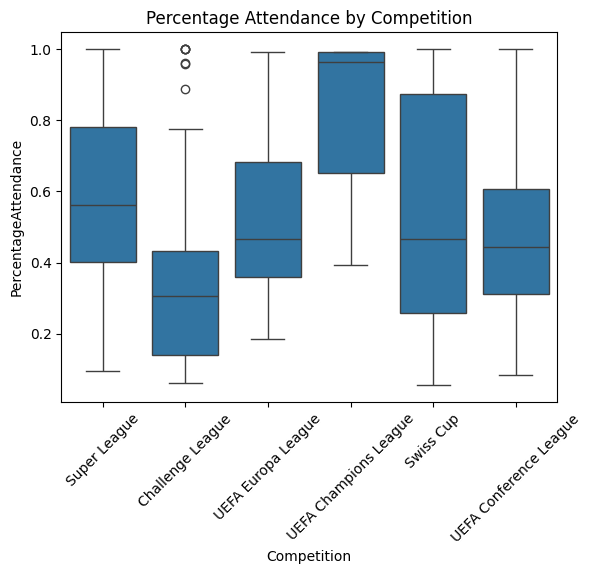

In [20]:
#Influence of Competition on percentage Attendance
sns.boxplot(x='Competition', y='PercentageAttendance', data=df)
plt.title("Percentage Attendance by Competition")
plt.xticks(rotation=45)
plt.show()

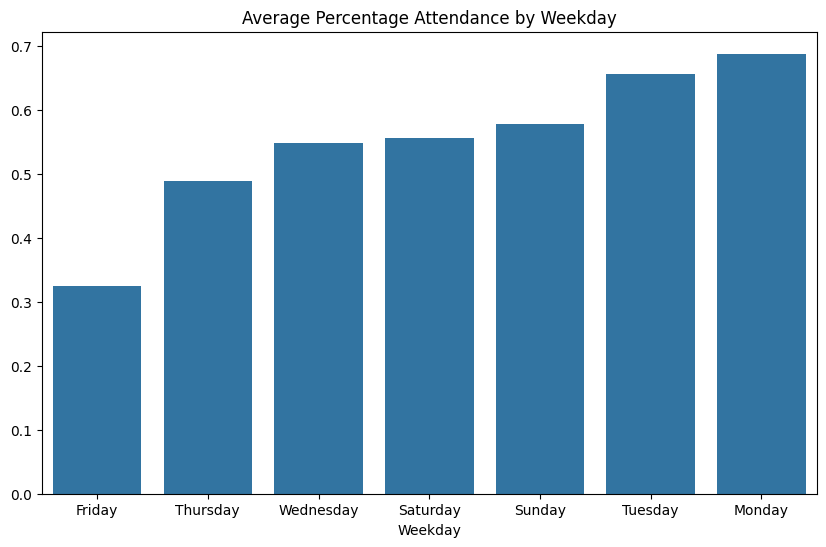

In [21]:
#Influence of the Weekday on percentage Attendance
plt.figure(figsize=(10, 6))
mean_attendance = df.groupby('Weekday')['PercentageAttendance'].mean().sort_values()
sns.barplot(x=mean_attendance.index, y=mean_attendance.values)
plt.title("Average Percentage Attendance by Weekday")
plt.show()

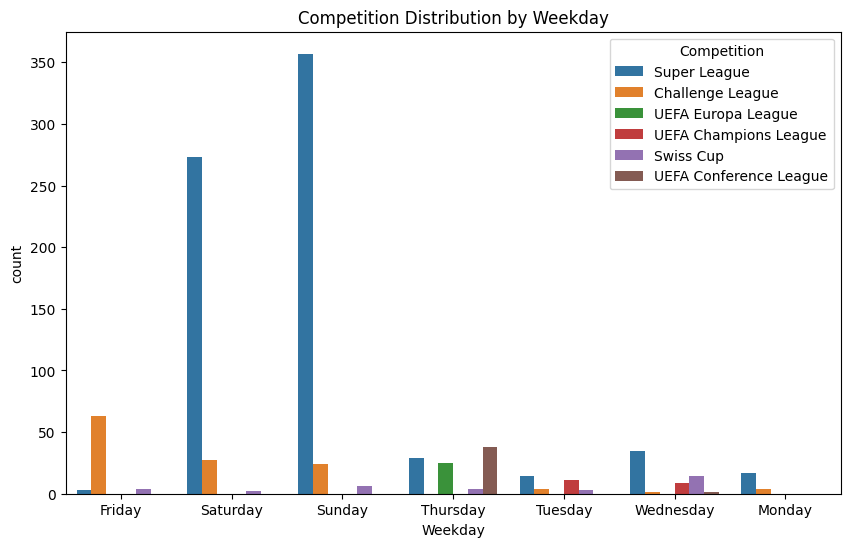

In [22]:
#Competitions on the different weekdays
plt.figure(figsize=(10, 6))
sns.countplot(x='Weekday', hue='Competition', data=df)
plt.title("Competition Distribution by Weekday")
plt.show()

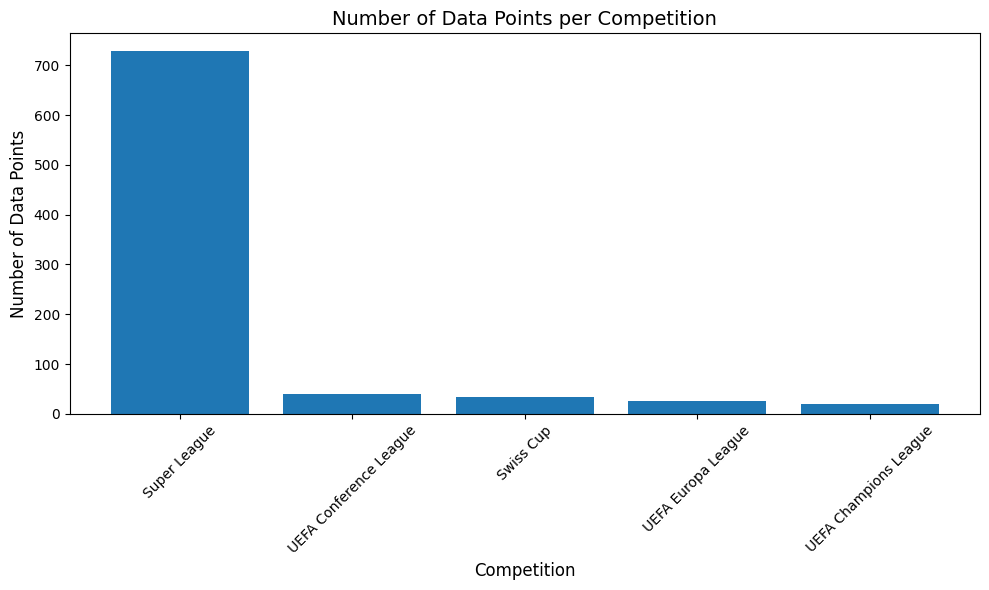

In [23]:
#Count of the number of Datapoints per competition
competitions = ['Competition_UEFA Champions League', 'Competition_UEFA Europa League',
                'Competition_Super League', 'Competition_Swiss Cup',
                'Competition_UEFA Conference League']

# Count number of Datapoints for each competition
competition_counts = {competition.split('_')[-1]: df_encoded[competition].sum() for competition in competitions}

competition_counts_df = pd.DataFrame(list(competition_counts.items()), columns=['Competition', 'Count'])

# Sort
competition_counts_df = competition_counts_df.sort_values(by='Count', ascending=False)

# Visualize
plt.figure(figsize=(10, 6))
plt.bar(competition_counts_df['Competition'], competition_counts_df['Count'])
plt.xlabel('Competition', fontsize=12)
plt.ylabel('Number of Data Points', fontsize=12)
plt.title('Number of Data Points per Competition', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

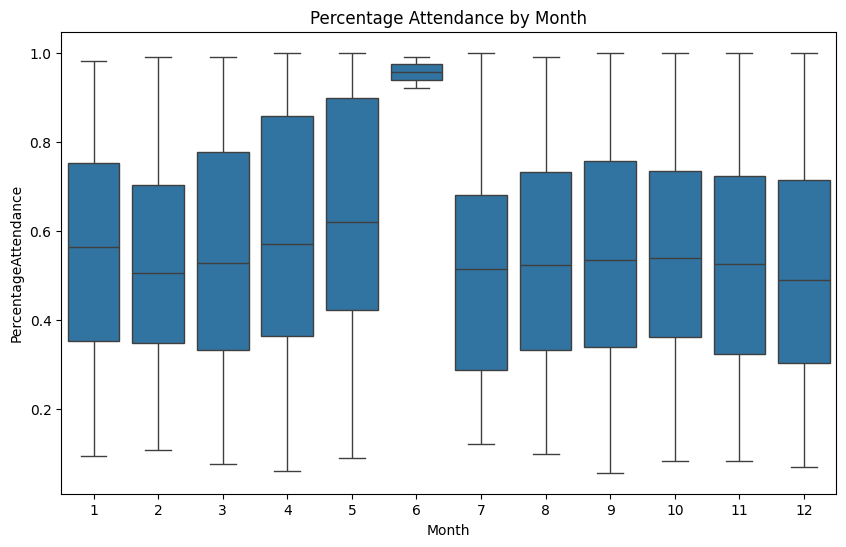

In [24]:
##Influence of the Month on percentage Attendance
plt.figure(figsize=(10, 6))
sns.boxplot(x='Month', y='PercentageAttendance', data=df)
plt.title("Percentage Attendance by Month")
plt.show()

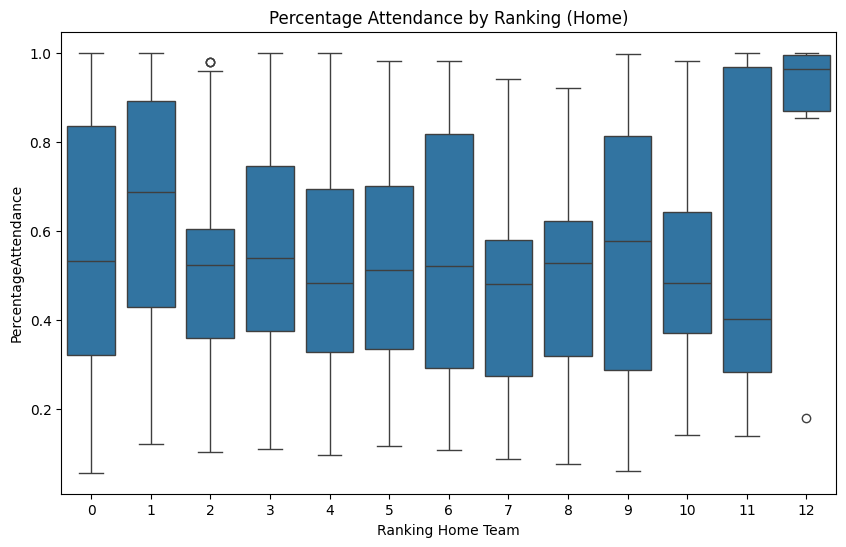

In [25]:
#Influence of Home Team Ranking on percentage Attendance
plt.figure(figsize=(10, 6))
sns.boxplot(x='Ranking Home Team', y='PercentageAttendance', data=df)
plt.title("Percentage Attendance by Ranking (Home)")
plt.show()

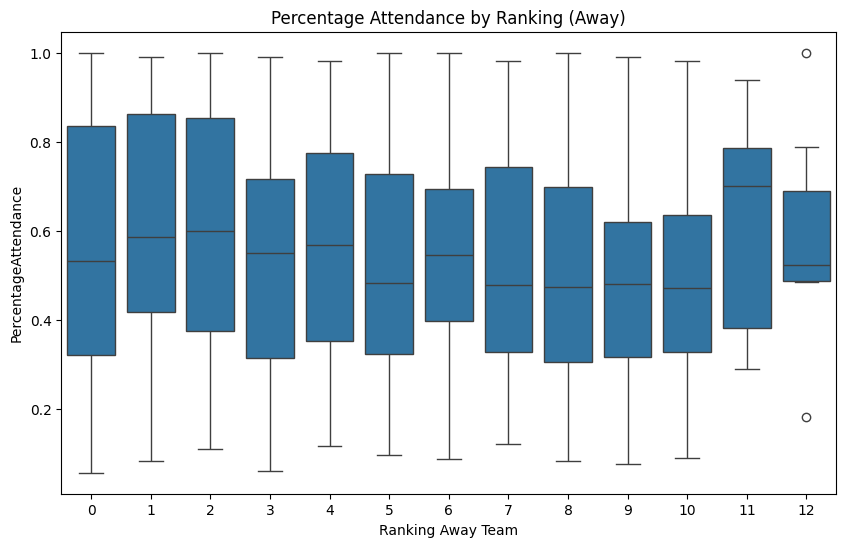

In [26]:
#Influence of Away Team Ranking on percentage Attendance
plt.figure(figsize=(10, 6))
sns.boxplot(x='Ranking Away Team', y='PercentageAttendance', data=df)
plt.title("Percentage Attendance by Ranking (Away)")
plt.show()

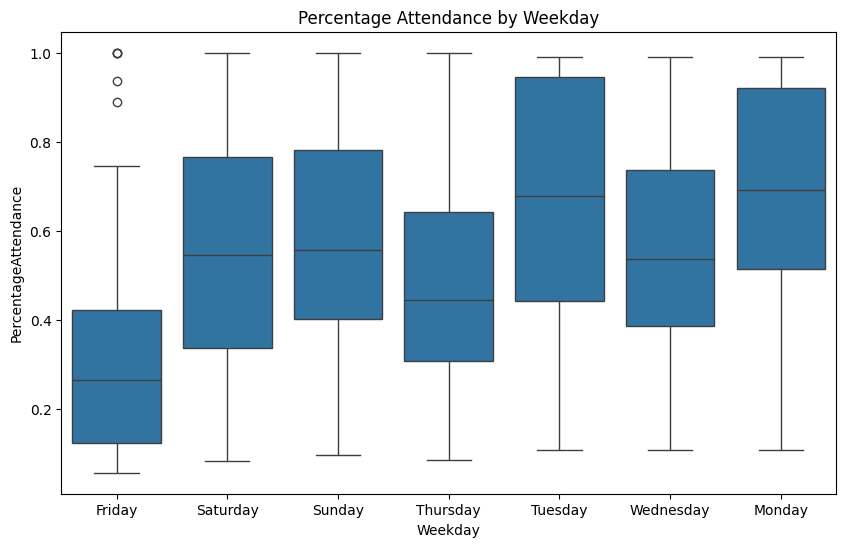

In [27]:
#Influence of the Weekday on percentage Attendance
plt.figure(figsize=(10, 6))
sns.boxplot(x='Weekday', y='PercentageAttendance', data=df)
plt.title("Percentage Attendance by Weekday")
plt.show()


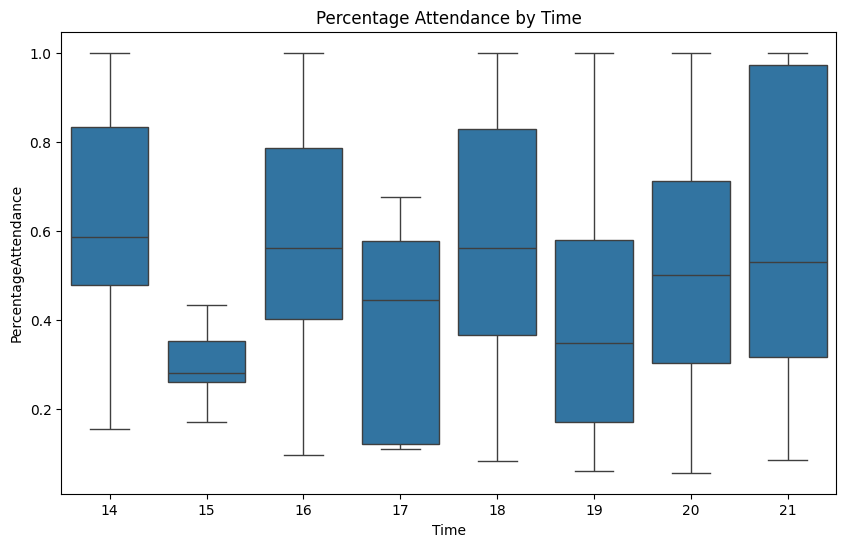

In [28]:
#Influence of Time on percentage Attendance
plt.figure(figsize=(10, 6))
sns.boxplot(x='Time', y='PercentageAttendance', data=df)
plt.title("Percentage Attendance by Time")
plt.show()

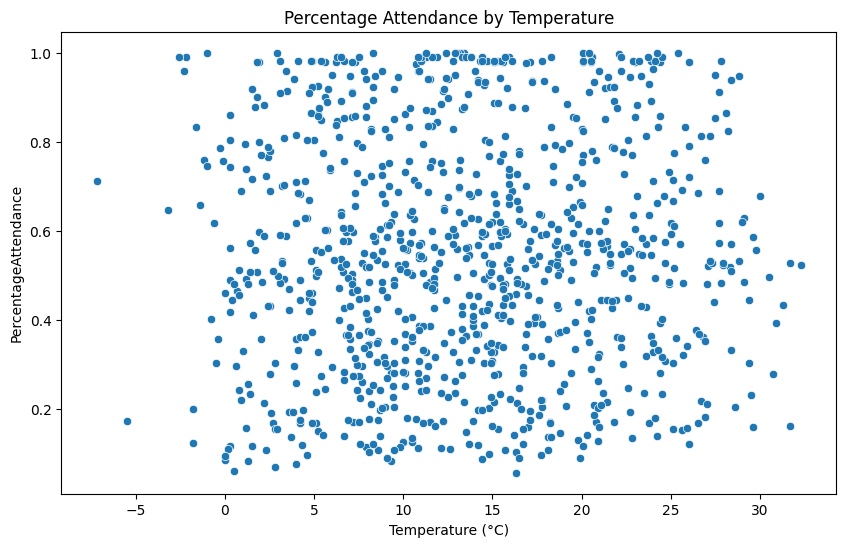

In [29]:
#Influence of Temperature on percentage Attendance
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Temperature (°C)', y='PercentageAttendance', data=df)
plt.title("Percentage Attendance by Temperature")
plt.show()

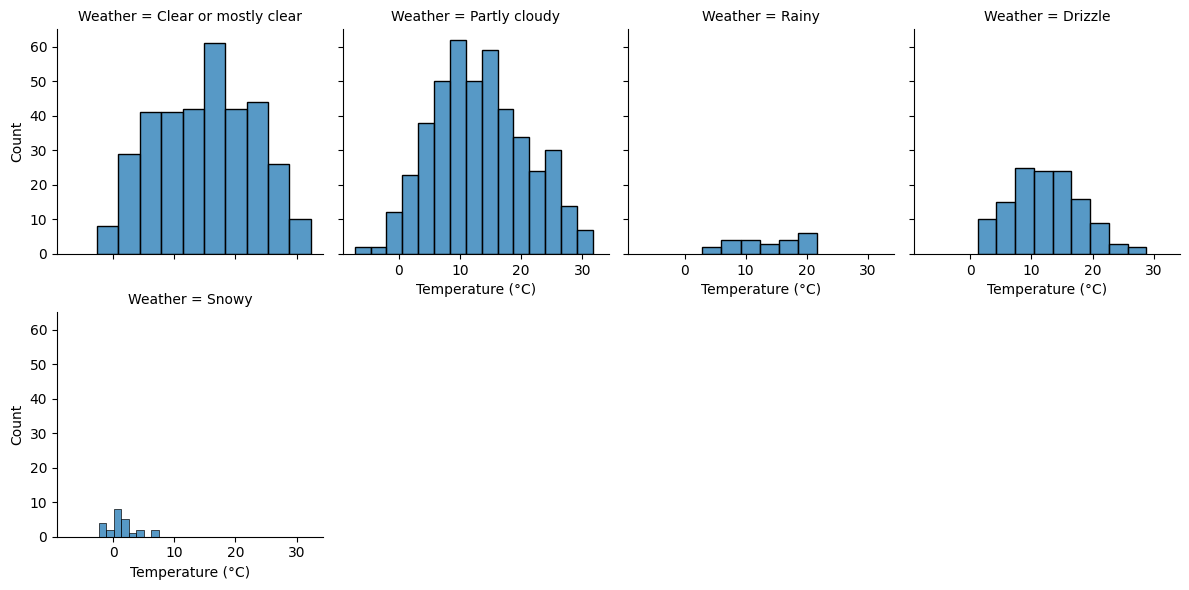

In [36]:
g = sns.FacetGrid(df, col="Weather", col_wrap=4)
g.map(sns.histplot, "Temperature (°C)")
plt.show()

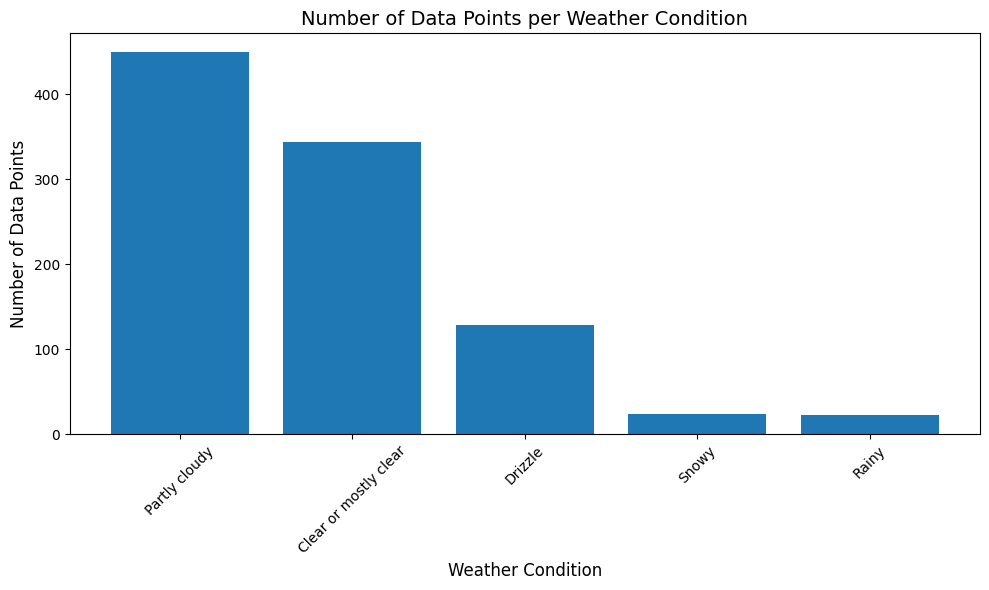

In [30]:
# Count number of Datapoints per Weather Condition
weather_conditions = [ 'Weather_Clear or mostly clear','Weather_Partly cloudy',
                      'Weather_Rainy', 'Weather_Drizzle', 'Weather_Snowy']

#Count number of Data Points for each weather condition
weather_counts = {weather.split('_')[-1]: df_encoded[weather].sum() for weather in weather_conditions}

#convert to Dataframe
weather_counts_df = pd.DataFrame(list(weather_counts.items()), columns=['Weather Condition', 'Count'])

# Sort
weather_counts_df = weather_counts_df.sort_values(by='Count', ascending=False)

# Visualize
plt.figure(figsize=(10, 6))
plt.bar(weather_counts_df['Weather Condition'], weather_counts_df['Count'])
plt.xlabel('Weather Condition', fontsize=12)
plt.ylabel('Number of Data Points', fontsize=12)
plt.title('Number of Data Points per Weather Condition', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

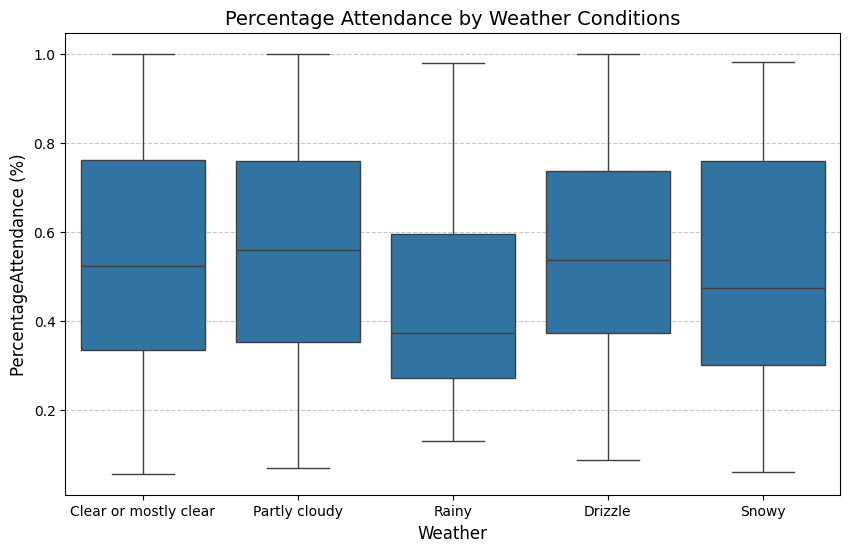

In [31]:
#Influence of Weather on percentage Attendance
plt.figure(figsize=(10, 6))
sns.boxplot(x='Weather', y='PercentageAttendance', data=df)
plt.title('Percentage Attendance by Weather Conditions', fontsize=14)
plt.xlabel('Weather', fontsize=12)
plt.ylabel('PercentageAttendance (%)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

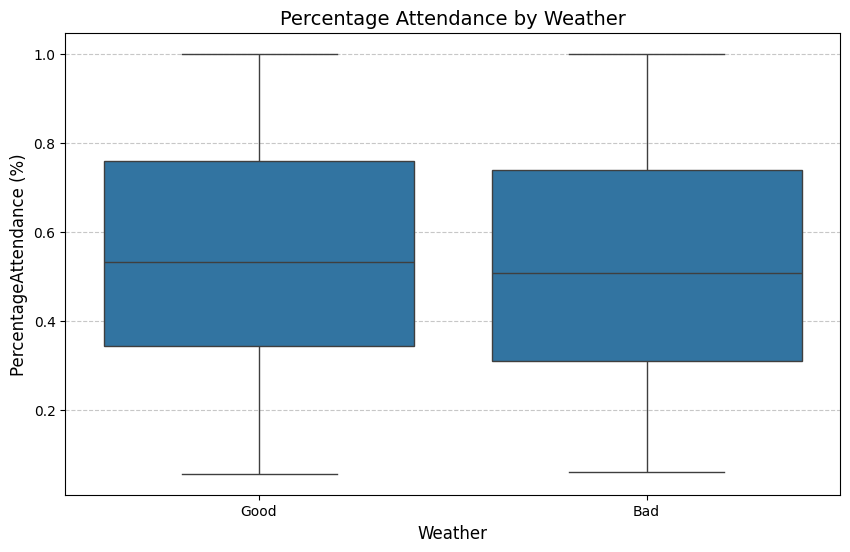

In [32]:
#Influence of Weather on percentage Attendance
plt.figure(figsize=(10, 6))
sns.boxplot(x='Weather GoodBad', y='PercentageAttendance', data=df)
plt.title('Percentage Attendance by Weather', fontsize=14)
plt.xlabel('Weather', fontsize=12)
plt.ylabel('PercentageAttendance (%)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

---
**Analysis**

Percentage attendance is influenced by several factors, as shown by the boxplots:

*   **Competition**: High-profile competitions such as the Champions League attract the highest attendance, while local leagues like the Challenge League generate less interest.

*   **Month**: Matches in May, typically season finales, exhibit the highest attendance, whereas winter months tend to have lower numbers.

*   **Team Rankings**: Home and away teams with higher rankings significantly boost attendance, while mid-tier rankings attract less interest.

*   **Weekdays and Time:** Evening matches and weekend games see higher attendance, whereas Fridays and early kick-off times experience lower turnout.

*   **Weather Conditions:** Good weather promotes higher attendance, while rain and snow act as deterrents.

In summary, attendance is influenced by factors such as competition, weather, team rankings, as well as time and day of the week.

## **Model**

In [33]:
# Target variable
target = 'PercentageAttendance'

# Columns, which should be excluded for the model
weather_columns = [col for col in df_encoded.columns if col.startswith('Weather_') or col == 'Temperature (°C)']

# Train- and Test-Split for the Model incl. Weather
X_weather = df_encoded.drop(columns=[target])
y_weather = df_encoded[target]
X_train_weather, X_test_weather, y_train_weather, y_test_weather = train_test_split(
    X_weather, y_weather, test_size=0.25, random_state=42
)

# Train- and Test-Split for the Model excl. Weather
X_without_weather = df_encoded.drop(columns=[target] + weather_columns)
y_without_weather = df_encoded[target]
X_train_without_weather, X_test_without_weather, y_train_without_weather, y_test_without_weather = train_test_split(
    X_without_weather, y_without_weather, test_size=0.25, random_state=42
)

In [34]:
X_train_weather

,Time,Ranking Home Team,Ranking Away Team,Temperature (°C),Month,Day,Goals Scored in Last 5 Games,Goals Conceded in Last 5 Games,Number of Wins in Last 5 Games,Derby,...,Time slot_Afternoon,Time slot_Evening,Time slot_Night,Weather GoodBad_Bad,Weather GoodBad_Good,Weather_Clear or mostly clear,Weather_Drizzle,Weather_Partly cloudy,Weather_Rainy,Weather_Snowy
907,20.0,10.0,12.0,24.9,8.0,10.0,12.0,6.0,4.0,0.0,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
536,16.0,7.0,9.0,9.3,2.0,19.0,7.0,10.0,2.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
473,18.0,6.0,8.0,19.3,10.0,15.0,5.0,9.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
127,16.0,8.0,2.0,11.6,12.0,15.0,7.0,9.0,2.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
650,16.0,5.0,2.0,14.9,8.0,6.0,8.0,11.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,16.0,2.0,1.0,5.0,12.0,1.0,13.0,3.0,4.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
280,14.0,2.0,1.0,1.9,12.0,19.0,9.0,6.0,2.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
872,18.0,5.0,3.0,17.7,5.0,18.0,6.0,5.0,2.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
446,16.0,5.0,9.0,24.5,9.0,4.0,11.0,7.0,4.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In [40]:
#Function to save the results of the different models in a dataframe for easier comparison / visualization

#Dataframe
results = pd.DataFrame(columns=["Model", "MSE", "RMSE", "R2"])

def evaluate_model(model_name, y_test, y_pred, results_df):

    #Calculation of metrics
    mse_value = mean_squared_error(y_test, y_pred)
    rmse_value = np.sqrt(mse_value)
    r2_value = r2_score(y_test, y_pred)

    # Add results to the Dataframe
    results_df = pd.concat([
        results_df,
        pd.DataFrame({
            "Model": [model_name],
            "MSE": [mse_value],
            "RMSE": [rmse_value],
            "R2": [r2_value]
        })
    ], ignore_index=True)

    return results_df

### Linear Regression

#### Linear Regression with Weather

In [41]:
#Add constant to the Trainingsset
X_train_linreg_weather = sm.add_constant(X_train_weather)

#Create Model and Fit
linreg_weather = sm.OLS(y_train_weather, X_train_linreg_weather).fit()

In [42]:
#Add Constant to the Testset
X_test_linreg_weather = sm.add_constant(X_test_weather)

#Make Prediction
y_pred_linreg_weather = linreg_weather.predict(X_test_linreg_weather)

In [43]:
#Save rsults to the Dataframe
results = evaluate_model("Linear Regression (weather)", y_test_weather, y_pred_linreg_weather, results)

<ipython-input-40-5c823f1f504d>:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([


#### Linear Regression without Weather

In [44]:
#Add constant to the Trainingsset
X_train_linreg_without_weather = sm.add_constant(X_train_without_weather)

#Creta Model and Fit
linreg_without_weather = sm.OLS(y_train_without_weather, X_train_linreg_without_weather).fit()

In [45]:
#Add constant to the Testset
X_test_linreg_without_weather = sm.add_constant(X_test_without_weather)

#Prediction
y_pred_linreg_without_weather = linreg_without_weather.predict(X_test_linreg_without_weather)

In [46]:
#Save rsults to the Dataframe
results = evaluate_model("Linear Regression (without weather)", y_test_without_weather, y_pred_linreg_without_weather, results)

#### Log Linear Regression with Weather

In [47]:
#Train Log Linear Regression
log_linreg_weather = sm.OLS(np.log(y_train_weather), X_train_linreg_weather).fit()

#Predict
y_pred_log_weather = log_linreg_weather.predict(X_test_linreg_weather)

#Normalize transformed values
y_pred_log_linreg_weather = np.exp(y_pred_log_weather)

In [48]:
#Save rsults to the Dataframe
results = evaluate_model("Log Linear Regression (weather)", y_test_weather, y_pred_log_linreg_weather, results)

#### Log Linear Regression without weather

In [49]:
#Train Log Linear Regression
log_linreg_without_weather = sm.OLS(np.log(y_train_without_weather), X_train_linreg_without_weather).fit()

#Predict Log linear Regression
y_pred_log_without_weather = log_linreg_without_weather.predict(X_test_linreg_without_weather)

#Normalize transformed values
y_pred_log_linreg_without_weather = np.exp(y_pred_log_without_weather)

In [50]:
#Save rsults to the Dataframe
results = evaluate_model("Log Linear Regression (without weather)", y_test_without_weather, y_pred_log_linreg_without_weather, results)

###Tree Based Models

#### Random Forest

In [51]:
#Random Forest incl. Weather
model_with_weather_rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=6,
    random_state=42
)

#Train Model
model_with_weather_rf.fit(X_train_weather, y_train_weather)

#Predict
y_pred_weather_rf = model_with_weather_rf.predict(X_test_weather)

# Random Forest excl. Weather
model_without_weather_rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=6,
    random_state=42
)

#Train Model
model_without_weather_rf.fit(X_train_without_weather, y_train_without_weather)

#Predict
y_pred_without_weather_rf = model_without_weather_rf.predict(X_test_without_weather)


In [52]:
#Save rsults to the Dataframe
results = evaluate_model("Random Forest (weather)", y_test_weather, y_pred_weather_rf, results)

In [53]:
#Save rsults to the Dataframe
results = evaluate_model("Random Forest (without weather)", y_test_without_weather, y_pred_without_weather_rf, results)

#### XGBoost

In [54]:
# XGBoost-Modell incl.Weather
#Parameter Grid for Hyperparameter Tuning
param_dist = {
    'n_estimators': [500, 700, 900],
    'learning_rate': [0.01, 0.05, 0.1 ],
    'max_depth': [5, 7, 9],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.5, 0.7, 0.9],
    'colsample_bytree': [ 0.4, 0.6, 0.8]
}

model_with_weather_xgb = XGBRegressor(random_state=42)

random_search_weather = RandomizedSearchCV(
    estimator=model_with_weather_xgb,
    param_distributions=param_dist,
    scoring='neg_mean_squared_error',
    n_iter=10,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

#Train
random_search_weather.fit(X_train_weather, y_train_weather)

best_xgb_weather = random_search_weather.best_estimator_
print("Beste Hyperparameter (Weather):", random_search_weather.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Beste Hyperparameter (Weather): {'subsample': 0.9, 'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 7, 'learning_rate': 0.01, 'colsample_bytree': 0.8}


In [55]:
#Save rsults to the Dataframe
results = evaluate_model("XGBoost (weather)", y_test_weather, best_xgb_weather.predict(X_test_weather), results)

In [56]:
#Parameter Grid for Hyperparameter Tuning
param_dist = {
    'n_estimators': [500, 700, 900],
    'learning_rate': [0.01, 0.05, 0.1 ],
    'max_depth': [5, 7, 9],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.5, 0.7, 0.9],
    'colsample_bytree': [ 0.4, 0.6, 0.8],
}

model_without_weather_xgb = XGBRegressor(random_state=42)

random_search_without_weather = RandomizedSearchCV(
    estimator=model_without_weather_xgb,
    param_distributions=param_dist,
    scoring='neg_mean_squared_error',
    n_iter=10,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Train Model excl. Wetter
random_search_without_weather.fit(X_train_without_weather, y_train_without_weather)

best_xgb_without_weather = random_search_without_weather.best_estimator_
print("Beste Hyperparameter (Without Weather):", random_search_without_weather.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Beste Hyperparameter (Without Weather): {'subsample': 0.9, 'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 7, 'learning_rate': 0.01, 'colsample_bytree': 0.8}


In [57]:
#Save rsults to the Dataframe
results = evaluate_model("XGBoost (without weather)", y_test_without_weather, best_xgb_without_weather.predict(X_test_without_weather), results)

In [58]:
results

,Model,MSE,RMSE,R2
0,Linear Regression (weather),0.024089,0.155207,0.647675
1,Linear Regression (without weather),0.023732,0.154053,0.652897
2,Log Linear Regression (weather),0.028628,0.169199,0.581290
3,Log Linear Regression (without weather),0.028417,0.168572,0.584385
4,Random Forest (weather),0.027494,0.165814,0.597873
5,Random Forest (without weather),0.027299,0.165225,0.600725
6,XGBoost (weather),0.020437,0.142957,0.701099
7,XGBoost (without weather),0.020023,0.141502,0.707151


---
**Analysis**

The model analysis reveals clear differences in the predictive performance of the various approaches:

**Linear Regression:**

*   Both models, with and without weather data, deliver solid results.

*   Interestingly, the model without weather data performs slightly better (higher R² value). This suggests that simple linear models cannot effectively utilize the additional information provided by weather data.

**Log-Linear Regression:**

*   The results are similar to those of linear regression but slightly worse overall.

*   This indicates that applying a log transformation to the target variable does not yield improvements in this case.


**Random Forest:**

*   Performance is better overall compared to linear models, both with and without weather data.

*   Again, the variant without weather data shows slightly higher predictive accuracy. Random Forest captures non-linear relationships more effectively but does not outperform XGBoost.

**XGBoost:**

*   XGBoost is the best-performing model, delivering the highest accuracy with and without weather data.

*   This demonstrates that XGBoost can effectively capture complex relationships between variables. The difference between models with and without weather data is minimal.



In [59]:
# Save model excl. weather, to implement in Streamlit
filename = 'finalized_model_without_weather.sav'
pickle.dump(model_without_weather_xgb, open(path + filename, 'wb'))

In [60]:
#Save model incl. weather, to implement in Streamlit
filename = 'finalized_model_with_weather.sav'
pickle.dump(model_with_weather_xgb, open(path + filename, 'wb'))

###Feature Analysis

In [61]:
# Calculate SHAP-values
explainer = shap.Explainer(best_xgb_weather, X_train_weather)
shap_values = explainer(X_train_weather)

# Formate as Dataframe
shap_df = pd.DataFrame(shap_values.values, columns=X_train_weather.columns)

# Mapping from Dummy-Features to Categories
categories = {
    'Home team Category': ['Home team Category_Top ranked', 'Home team Category_Medium ranked',
                           'Home team Category_Bottom ranked', 'Home team Category_Not ranked'],
    'Opposing team Category': ['Opposing team Category_Top ranked', 'Opposing team Category_Medium ranked',
                               'Opposing team Category_Bottom ranked', 'Opposing team Category_Not ranked'],
    'Game day': ['Game day_Weekday', 'Game day_Weekend'],
    'Time slot': ['Time slot_Afternoon', 'Time slot_Evening', 'Time slot_Night'],
    'Weather': ['Weather GoodBad_Good', 'Weather GoodBad_Bad'],
    'Competition': ['Competition_UEFA Champions League', 'Competition_Super League', 'Competition_UEFA Europa League', 'Competition_UEFA Conference League'],
}

 99%|===================| 721/726 [00:19<00:00]       

In [ ]:
category_shap = []

#Iterate through Categories / Subcategories, to calculatze individual SHAP values
for category, subcategories in categories.items():
    for subcategory in subcategories:
        if subcategory in shap_df.columns:
            # Summiere die absoluten SHAP-Werte
            shap_importance = shap_df[subcategory].sum()
        else:
            shap_importance = 0
        category_shap.append({'Category': category, 'Subcategory': subcategory.split('_')[-1], 'SHAP Importance': shap_importance})

# Convert to Dataframe
category_shap_df = pd.DataFrame(category_shap)

In [ ]:
formatted_data = []

# Iteriere through categories
for category, subcategories in categories.items():

    first_entry = True
    for subcategory in subcategories:
        # Get SHAP value
        shap_importance = category_shap_df.loc[
            (category_shap_df['Category'] == category) &
            (category_shap_df['Subcategory'] == subcategory.split('_')[-1]),
            'SHAP Importance'
        ].sum()


        formatted_data.append({
            'Category': category if first_entry else '',
            'Subcategory': subcategory.split('_')[-1],
            'SHAP Importance': shap_importance
        })
        first_entry = False  # Danach bleibt die Kategorie leer

#Convert into Dataframe
formatted_table_df = pd.DataFrame(formatted_data)
formatted_table_df

,Category,Subcategory,SHAP Importance
0,Home team Category,Top ranked,0.271626
1,,Medium ranked,0.441492
2,,Bottom ranked,0.021923
3,,Not ranked,0.000000
4,Opposing team Category,Top ranked,-0.002878
5,,Medium ranked,0.032661
6,,Bottom ranked,-0.000174
7,,Not ranked,0.007897
8,Game day,Weekday,-0.043431
9,,Weekend,-0.001726


---
**Analysis**

The analysis of feature importance highlights that both internal factors, such as team strength, and external conditions, such as weather and scheduling, play a critical role in predicting stadium attendance:


*   **Team Categories:**The strength of the home team (particularly mid-tier and top teams) has the most significant positive impact on attendance.
The opponent's category, however, has only a minor influence.

*   **Weekdays and Time:**Weekend games and afternoon matches have a slightly positive effect on attendance, whereas evening games tend to attract fewer spectators.

*   **Weather**:Poor weather has the most substantial negative impact on attendance, while good weather only shows a slight positive effect.


Overall, the findings emphasize that both sporting factors and external conditions, such as timing and weather, must be considered to effectively predict attendance.

### Predicition Analysis

In [ ]:
# Erstelle ein DataFrame mit den tatsächlichen und vorhergesagten Werten
results_df = pd.DataFrame({
    'Actual': y_test_without_weather.values,
    'Predicted': best_xgb_weather.predict(X_test_weather)
})

results_df

,Actual,Predicted
0,0.917470,0.812873
1,0.084104,0.349413
2,0.161947,0.265646
3,0.979140,0.728989
4,0.869679,0.794888
...,...,...
237,0.684676,0.508691
238,0.676984,0.578389
239,0.851166,0.848444
240,0.366407,0.230946


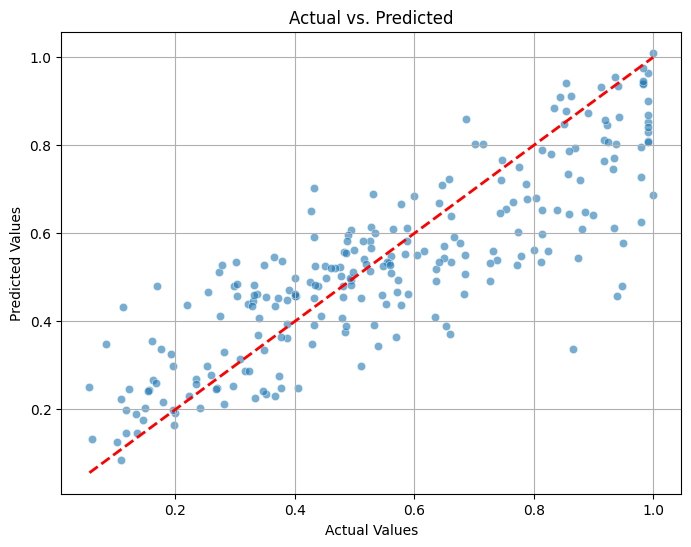

In [ ]:
#Visualization of Actual vs. Predicted Values
plt.figure(figsize=(8, 6))
sns.scatterplot(x=results_df['Actual'], y=results_df['Predicted'], alpha=0.6)
plt.plot([results_df['Actual'].min(), results_df['Actual'].max()],
         [results_df['Actual'].min(), results_df['Actual'].max()],
         color='red', linestyle='--', linewidth=2)  # Diagonale Linie
plt.title('Actual vs. Predicted')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()

---
**Analysis**

**Alignment with the Diagonal:**

*   Most points lie close to the red line, indicating that the model predicts the actual values well.

*   Particularly in the middle range (between 0.4 and 0.8), the model demonstrates high accuracy.

**Distribution of Points:**

*   There is moderate scatter around the diagonal, suggesting that while the model is not perfect, it still exhibits a strong correlation between actual and predicted values.

*   Some outliers are evident, especially at very low (below 0.2) and very high values (above 0.8), where the model is less precise.

*   For very low values, the model tends to overestimate, whereas for very high values, it tends to underestimate

**Model Performance:**

*   The alignment of points along the diagonal indicates a well-trained model that captures the underlying patterns in the data effectively.

*   Predictions are particularly reliable for the range between 0.2 and 0.8, while performance deteriorates for very low and very high values.

In [ ]:
#Average Attendance of Each Team
average_attendance = df.groupby('Home Team')['PercentageAttendance'].mean().reset_index()

In [ ]:
#Filter out only CL Games
cl_games = df[df['Competition'] == 'UEFA Champions League']

In [ ]:
#DF which compares CL Attendances compared to Avg. Attendance
# Used to analyse, why CL games have a neg. Influence
merged_df = cl_games.merge(average_attendance, on='Home Team', how='left')
merged_df = merged_df.rename(columns={
    'PercentageAttendance_x': 'CL Percentage Attendance',  # Spalte für CL-Spiele
    'PercentageAttendance_y': 'Avg Percentage Attendance'  # Spalte für Durchschnitt
})

In [ ]:
merged_df[['Home Team', 'CL Percentage Attendance', 'Avg Percentage Attendance', 'Weather']]

,Home Team,CL Percentage Attendance,Avg Percentage Attendance,Weather
0,FC Basel,0.758621,0.543646,Partly cloudy
1,FC Basel,0.531523,0.543646,Drizzle
2,BSC Young Boys,0.979140,0.858099,Partly cloudy
3,BSC Young Boys,0.615549,0.858099,Clear or mostly clear
4,BSC Young Boys,0.665293,0.858099,Clear or mostly clear
5,BSC Young Boys,0.492465,0.858099,Partly cloudy
6,BSC Young Boys,0.979140,0.858099,Partly cloudy
7,BSC Young Boys,0.862033,0.858099,Clear or mostly clear
8,BSC Young Boys,0.979140,0.858099,Partly cloudy
9,FC Zürich,0.392162,0.514943,Partly cloudy


---
**Final Model Analysis & Issues**

*   A central problem of our models lies in the limited number of data points. For many stadiums, there are few or even no data points with varying attendance figures. The same issue applies to specific features such as the Champions League or weather conditions, where insufficient data is also available. With only 20 data points for Champions League matches and 39 for Europa League matches, the model is unable to accurately interpret these relationships.

*   **Impact of Competitions and Weekdays:** Data exploration clearly showed that Champions League and Europa League matches tend to have higher attendance figures. This higher attendance should theoretically also be reflected in the weekdays, as international matches are often held midweek. However, this effect is overshadowed by the large number of Super League matches in the dataset, which often exhibit lower attendance. As a result, the model is unable to reliably separate the different effects of weekdays and competitions. Additionally, there are a few exceptions in Champions League matches with lower attendance, where it becomes apparent that weather conditions can have an influence.

*   **Weather as a Weakly Explaining Variable:**An imbalance is also evident in weather conditions: the majority of data points represent good weather, while data points for bad weather are sparse. Moreover, these few data points are often influenced by other factors, such as derby matches or international competitions. As a result, the model is unable to accurately capture the isolated impact of bad weather. It is likely that weather overall has a smaller influence on attendance than originally assumed, as reflected in the similar model performance with and without weather data.

  - **Advance Ticket Purchases:**Most tickets are purchased prior to the match, often without accurate weather forecasts. Poor weather conditions do not necessarily result in fans choosing not to attend.
  
  - **Stability of the Fan Base:**
The core fans of a club are hardly influenced by weather conditions, meaning only a small portion of the audience is dependent on the weather.

*   **Challenges in Model Interpretation:**Data exploration has shown that certain features (such as weather, weekday, and time) correlate with attendance. However, the limited number of data points makes it difficult for the model to reliably interpret these relationships. Additionally, some features, such as time or weekday, appear to have less influence on attendance than initially assumed, as similar attendance numbers are observed across different conditions.

*   **Model Behavior with Extreme Values:**
Another weakness of the model is its tendency to overestimate attendance values in the lower range and underestimate them in the upper range. This suggests that the model struggles to accurately predict extreme values (such as highly attended Champions League matches or poorly attended Super League matches). The causes for this are:

  - **Conflicting Data:** While Champions League and Europa League matches often exhibit high attendance, Super League matches with low attendance during the week dominate the dataset. These two factors create inconsistencies within the data.
  - **Too Few Extreme Data Points:**With only a limited number of data points for highly attended matches (e.g., international competitions), the model tends to predict middle-range values, which are accurate in the majority of cases (Super League matches).

*    **Missing Variables and External Factors:**
In addition to the previously mentioned issues with the variables, there are other factors that strongly influence attendance but were not included in the dataset:

  - **Differences Between Fan Bases:**Clubs have significantly different fan bases. Some clubs consistently show high attendance regardless of external factors such as weather or competition. This is particularly evident in clubs with a strong core fan base.

  - **Insufficient Data Points Per Club:**With fewer than 100 data points per club, these differences in fan bases cannot be effectively modeled. To account for such differences, additional variables like the number of members, season ticket holders, or overall fan activity should have been included. Alternatively, focusing on a single club could have eliminated these internal differences.



  ---


 **Summary & Recommendations:**
Overall, the models provide interesting insights and solid results but face limitations due to the restricted data base and the lack of consideration for key influencing factors. This is primarily caused by low data availability, especially for extreme values and rare conditions (e.g., Champions League matches, poor weather). Furthermore, important influencing factors (e.g., fan base dynamics, number of members) were not included in our model, even though they likely play an explanatory role in attendance.

For future analyses, the focus should therefore be on significantly expanding the data base and introducing additional explanatory variables to improve the precision of predictions.
  





